## Import Needed Libraries

In [ ]:
import numpy as np
import pandas as pd
import re
import random
import transformers
import matplotlib.pyplot as plt
import json
import pickle
import torch
from tqdm import tqdm

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Import libraries for Transformer

In [ ]:
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelBinarizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Import BERT-base pretrained model
bert_model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Loading the Data

In [ ]:
df = pd.read_csv("processed_data.csv", engine='python')
df.head()

,tag,patterns,responses
0,Cuts,"['What to do if Cuts?', 'How to cure Cuts?', '...",['Wash the cut properly to prevent infection a...
1,Abrasions,"['how do you treat abrasions?', 'Do Abrasions ...",['Begin with washed hands.Gently clean the are...
2,stings,"['How do you treat Sting?', 'Stings', 'What to...",['Remove any stingers immediately. Some expert...
3,Splinter,"['How to remove Splinters', 'How to cure Splin...",['1. SOAK IT IN EPSOM SALTS. Dissolve a cup of...
4,Sprains,"['How do you treat a sprain?', 'what to do if ...","[""Use an ice pack or ice slush bath immediatel..."


In [ ]:
import json

# Create the intent dictionary
intent_dict = {"intents": []}

for ind in df.index:
    pattern = df['patterns'][ind].strip()
    response = df['responses'][ind].strip()

    # Optional: create a tag from the Description (you can customize this logic)
    tag = df['tag'][ind].lower().strip()

    intent_entry = {
        "tags": [tag],
        "patterns": [pattern],
        "responses": [response]
    }

    intent_dict["intents"].append(intent_entry)

# Preview the first 2
print(intent_dict["intents"][:2])

# Save to JSON file
with open("chatbot_intents.json", "w") as f:
    json.dump(intent_dict, f, indent=4)

[{'tags': ['cuts'], 'patterns': ["['What to do if Cuts?', 'How to cure Cuts?', 'Which medicine to apply for Cuts?', 'what to apply on cuts?', 'Cuts']"], 'responses': ["['Wash the cut properly to prevent infection and stop the bleeding by applying pressure for 1-2minutes until bleeding stops. Apply Petroleum Jelly to make sure that the wound is moist for quick healing. Finally cover the cut with a sterile bandage. Pain relievers such as acetaminophen can be applied.']"]}, {'tags': ['abrasions'], 'patterns': ["['how do you treat abrasions?', 'Do Abrasions cause scars?', 'Abrasions', 'what to do if abrasions?', 'Which medicine to apply for abrasions?', 'How to cure abrasions?']"], 'responses': ["['Begin with washed hands.Gently clean the area with cool to lukewarm water and mild soap. Remove dirt or other particles from the wound using sterilized tweezers.For a mild scrape that’s not bleeding, leave the wound uncovered.If the wound is bleeding, use a clean cloth or bandage, and apply gent

## Save the intents and all the needed information

In [ ]:
words=[]
classes=[]
documents=[]
ignore_letters=['?','!','.',',']
lemmatizer = WordNetLemmatizer()

def get_bert_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

for intent in intent_dict['intents']:
    for pattern in intent['patterns']:
        if isinstance(pattern, str):
            word_list = tokenizer.tokenize(pattern)
            words.extend(word_list)
            documents.append((pattern, intent['tags'][0]))
            if intent['tags'][0] not in classes:
                classes.append(intent['tags'][0])

words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
words = sorted(set(words))
classes = sorted(set(classes))

pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))

In [ ]:
# Prepare training data
training = []
output_empty = [0] * len(classes)
label_binarizer = LabelBinarizer()
label_binarizer.fit(classes)

# Add tqdm to loop
for document in tqdm(documents, desc="Processing documents"):
    pattern = document[0]
    tag = document[1]
    embedding = get_bert_embedding(pattern)
    output_row = label_binarizer.transform([tag])[0]
    training.append((embedding.flatten(), output_row))

random.shuffle(training)
training = np.array(training, dtype=object)

train_x = np.array([item[0] for item in training])
train_y = np.array([item[1] for item in training])

In [34]:
# Define model
model=Sequential()
model.add(Dense(128,input_shape=(len(train_x[1]),),activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(train_y[0]),activation='softmax'))


model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 44)             │         2,860 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,548 (427.92 KB)

 Trainable params: 109,548 (427.92 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy','Precision','Recall'])

# Train model
hist = model.fit(train_x, train_y, epochs=50, batch_size=8, callbacks=[early_stop])

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - Precision: 0.9606 - Recall: 0.7310 - accuracy: 0.8044 - loss: 0.7609
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.8935 - Recall: 0.7348 - accuracy: 0.8331 - loss: 0.5289 
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.9728 - Recall: 0.6876 - accuracy: 0.8417 - loss: 0.6287 
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.9813 - Recall: 0.8617 - accuracy: 0.9440 - loss: 0.3658 
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - Precision: 1.0000 - Recall: 0.7791 - accuracy: 0.8533 - loss: 0.5092
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.9185 - Recall: 0.8103 - accuracy: 0.8792 - loss: 0.4748 
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 1.0000 - Recall: 0.8704 - accuracy: 0.9795 - loss: 0.2226 
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.8802 - Recall: 0.6521 - accuracy: 0.7693 - loss: 0.6443 
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9m

In [44]:
model.save('chatbot_model.h5')
model.save('chatbot_model.keras')

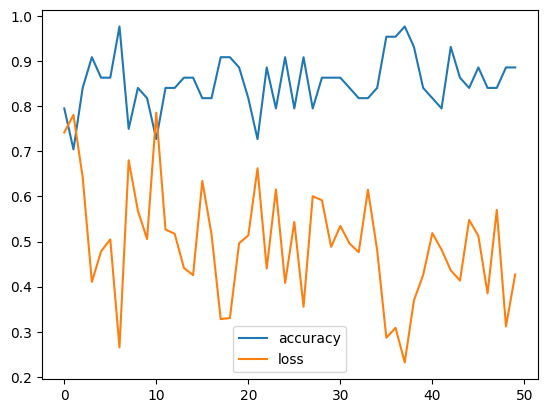

In [45]:
plt.plot(hist.history['accuracy'],label='accuracy')
plt.plot(hist.history['loss'],label='loss')
# plt.show()
plt.legend()

In [46]:
# Load the model for prediction
model = load_model('chatbot_model.h5')

def predict_class(sentence):
    embedding = get_bert_embedding(sentence)
    res = model.predict(embedding)[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = [{'intent': classes[r[0]], 'probability': str(r[1])} for r in results]
    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]['intent']
    for i in intents_json['intents']:
        if tag in i['tags']:
            return random.choice(i['responses'])
    return "Sorry, I don't understand."

print("GO! BOT IS RUNNING")

while True:
    message = input("")
    if message.lower() in ['quit', 'exit']:
        print("Goodbye")
        break
    ints = predict_class(message)
    if ints:
        res = get_response(ints, intent_dict)
        print(f"Bot: {res}")
    else:
        print("Bot: Sorry, I don't understand.")

GO! BOT IS RUNNING
how do i treat a burn
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Bot: [' ']
how do i treat a burn
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Bot: [' ']
burn
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Bot: ['Remove any stingers immediately. Some experts recommend scraping out the stinger with a credit card. Applying ice to the site may provide some mild relief. Apply ice for 20 minutes once every hour as needed. Wrap the ice in a towel or keep a cloth between the ice and skin to keep from freezing the skin. Taking an antihistamine such as diphenhydramine (Benadryl) or a nonsedating one such as loratadine (Claritin) will help with itching and swelling. Take acetaminophen (Tylenol) or ibuprofen (Motrin)for pain relief as needed. Wash the sting site with soap and water. Placing hydrocortisone cream on the sting can help relieve redness, itching, and swelling.']
hi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Bot: Sorry, I don't understand.
cuts
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Bot: ['Was

In [47]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Evaluate the model
y_pred = model.predict(train_x)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted class labels
y_true_classes = np.argmax(train_y, axis=1)  # Get the true class labels

# Calculate and print metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(report)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Accuracy: 1.0000
F1 Score: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1

## Performance Metrics Overview
Accuracy: 1.0000
The model correctly predicted the class for 100% of the samples in the test set. An accuracy of 1.0000 indicates that every prediction made by the model matched the true labels.

### F1 Score: 1.0000
The F1 score is also 1.0000, which signifies perfect balance between precision and recall. This means the model not only made correct predictions but also did so consistently across all classes.

## Detailed Classification Report
The classification report provides a more granular view of your model's performance for each class:


### Precision:
 The ratio of true positive predictions to the total predicted positives.
A precision of 1.00 for all classes means that every positive prediction made by the model was correct.

### Recall:
 The ratio of true positive predictions to the actual positives.
A recall of 1.00 indicates that the model identified all actual positive instances correctly for each class.

### F1-Score:
The harmonic mean of precision and recall.
An F1 score of 1.00 across all classes confirms that the model is performing perfectly without any false positives or false negatives.

### Support:
The number of actual occurrences of each class in the dataset.
Each of the 44 classes had 1 sample, and the model correctly predicted all of them.

## Summary of Results
Overall Performance: The model achieved perfect scores across all metrics, indicating it is highly effective in classifying the test data.

Macro Average: This shows the average performance across all classes without considering class imbalance. A macro average of 1.00 confirms that every class performed equally well.

Weighted Average: This takes into account the number of samples in each class. Since the test set was perfectly balanced, the weighted average of 1.00 also indicates consistent performance across all classes.